<h1>PHY 2200 - Computational Physics</h1>
<h2>Spring 2023</h2>

<h2>Physical applications of RK4</h2>

In [1]:
import numpy as np
from matplotlib import pyplot as plt

The purpose of this section is to use the basic RK4 method to explore models. To this end, let's recap and generalize our RK4 method. To summarize where we are, we can take a first-order differential equation of the form

$$\frac{dx}{dt} = f(x,t)$$

and approximate the solution by slicing the time interval into tiny steps of size $\Delta t$. Given $x_{0} = x(0)$, we can compute

$$x_{n+1} = x_{n} + \frac{1}{6}\left(k_{1} + 2k_{2} +2k_{3}+ k_{4}\right),$$

where 

$$k_{1} = \Delta t f\left(x_{n},t_{n}\right)$$
$$k_{2} = \Delta t f\left(x_{n} + \frac{1}{2}k_{1},t_{n} + \frac{1}{2}\Delta t\right)$$
$$k_{3} = \Delta t f\left(x_{n} + \frac{1}{2}k_{2},t_{n} + \frac{1}{2}\Delta t\right)$$
$$k_{4} = \Delta t f\left(x_{n} + k_{3},t_{n} + \Delta t\right)$$
$$t_{n} = n\Delta t$$

Great! But this only applies to a single <b>first order differential equation</b>. Consider the <b>van der Pol</b> oscillator, which describes a certain type of circuit employing vacuum tubes:

$$\frac{d^{2}x}{dt^{2}} - \mu(1-x^{2})\frac{dx}{dt} + x = 0$$

How does one use Runge-Kutta methods for a higher-order equation (note the second derivative) like this? On a related note, look at the following "predator-prey" model for a popualation of rabbits ($r(t)$) and foxes ($f(t)$)

$$\frac{dr}{dt} = \alpha r -\beta r f$$

$$\frac{df}{dt} = -\delta rf + \gamma f$$

We say these equations are <b>coupled</b> because each equation contains both unknown functions so the dynamics of each is affected by both values. As it turns out, the higher-order equations are <i>equivalent</i> to a (potentially) coupled system of first order equations. If we take the van der Pol oscillator and define

$$y = \frac{dx}{dt}$$

as a new function, the van der Pol equation becomes

$$\frac{dy}{dt} - \mu(1-x^{2})y + x = 0$$

since $\frac{d^{2}x}{dt^{2}} = \frac{dy}{dt}$. Now it's certainly true that $x$ and $y$ are not independent (one is the derivative of the other), but using this redundant notation we can summarize the system in terms of two first-order equations:

$$\frac{dx}{dt} = y$$
$$\frac{dy}{dt} = -x+\mu(1-x^{2})y$$

In <i>this</i> case, the second equation couples the two variables. This trick can be repeated for higher-order equations. So now both problems are reduced to the same class: how to solve coupled equations? The <i>problem</i> is that we can't solve one without knowing the other in order to apply Runge-Kutta. The <i>solution</i> is to do Runge-Kutta on both at the same time. Hang on here because the notation becomes a little nauseating. Given

$$\frac{dx}{dt} = F(x,y,t)$$
$$\frac{dy}{dt} = G(x,y,t)$$ 

for some functions $F(x,y,t)$ and $G(x,y,t)$, we assume we know $x_{0} = x(0)$ and $y_{0} = y(0)$. Then 

$$x_{n+1} = x_{n} + \frac{1}{6}\left(k_{1x}+2k_{2x}+2k_{3x} + k_{4x}\right)$$

$$y_{n+1} = y_{n} + \frac{1}{6}\left(k_{1y}+2k_{2y}+2k_{3y} + k_{4y}\right)$$

where 

$$k_{1x} = \Delta t F(x_{n},y_{n},t_{n})$$

$$k_{1y} = \Delta t G(x_{n},y_{n},t_{n})$$

$$k_{2x} = \Delta t F\left(x_{n}+\frac{1}{2}k_{1x},y_{n}+\frac{1}{2}k_{1y},t_{n} + \frac{1}{2}\Delta t\right)$$

$$k_{2y} = \Delta t G\left(x_{n}+\frac{1}{2}k_{1x},y_{n}+\frac{1}{2}k_{1y},t_{n} + \frac{1}{2}\Delta t\right)$$

$$k_{3x} = \Delta t F\left(x_{n}+\frac{1}{2}k_{2x},y_{n}+\frac{1}{2}k_{2y},t_{n} + \frac{1}{2}\Delta t\right)$$

$$k_{3y} = \Delta t G\left(x_{n}+\frac{1}{2}k_{2x},y_{n}+\frac{1}{2}k_{2y},t_{n} + \frac{1}{2}\Delta t\right)$$

$$k_{4x} = \Delta t F\left(x_{n}+k_{3x},y_{n}+k_{3y},t_{n} + \Delta t\right)$$

$$k_{4y} = \Delta t G\left(x_{n}+k_{3x},y_{n}+k_{3y},t_{n} + \Delta t\right)$$

In principle, <i>that's it</i>. It will make our lives a little easier, especially when generalizing to higher-order systems, to add one extra step. Let's take the van der Pol oscillator. As a first step, let's define a function that evaluates $\frac{dx}{dt}$ and $\frac{dy}{dt}$ given $x$ and $y$ (and $t$, but that's not needed in this case). 

As an attempt at "good" practice, we'll pass in the parameters (in this case just $\mu$) as an array. This practice will generalize nicely to more complicated systems with multiple parameters without having to restructure much. Additionally, we'll store all dynamical variables in a <i>single</i> array `x`, $x(t)\rightarrow$ `x[0]`, $y(t)\rightarrow$ `x[1]`. This might seem strange, but it simplifies the notation greatly.

In [3]:
def vdpF(x,t,param):
    μ = param[0]
    return np.array([x[1],-x[0]+μ*(1-x[0]**2)*x[1]])

Below is a <i>generic</i> function to compute a single RK4 step for some system of any number of variables $\vec{x}(t)$ with independent variable $t$, step size `dt`, and some array of parameters. We don't need to know what the parameters are (or even how many there) because we ultimately just pass them to the derivative function which should be written to extract them correctly. The following function can (and <i>should</i>) be reused for every single exercise in this notebook. You have earned it.

In [4]:
def rk4step(x,t,dxdt,dt,param):
    xn = np.zeros(len(x))
    
    k1 = dt*dxdt(x,t,param)
    k2 = dt*dxdt(x+0.5*k1,t+0.5*dt,param)
    k3 = dt*dxdt(x+0.5*k2,t+0.5*dt,param)
    k4 = dt*dxdt(x+k3,t+dt,param)
    
    for i in range(0,len(x)):
        xn[i] = x[i] + (1.0/6.0)*(k1[i]+2*k2[i]+2*k3[i]+k4[i])
    return xn

Now we can apply RK4 to the van der pol system. We'll take $\mu = 0.6$ and $x(0) = 1$, $y(0) = 0$. Note that for $\mu = 0$, you get a simple harmonic oscillator. Always check cases like this to make sure you get results that seem reasonable.

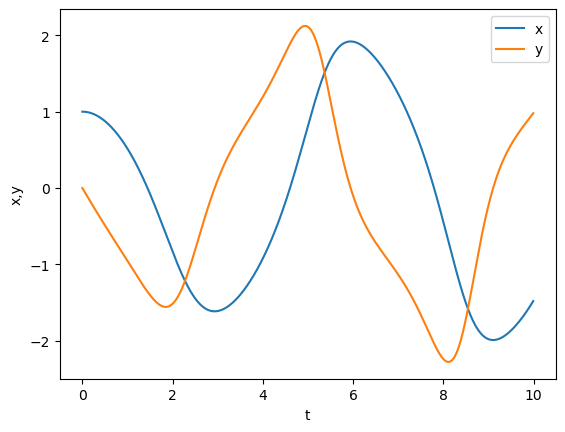

In [5]:
N = 1000
dt = 0.01
t = np.linspace(0,(N-1)*dt,N)

μ = 0.60 #μ
param = np.array([μ])
x = np.zeros(N)
y = np.zeros(N)

x[0] = 1.0
y[0] = 0.0

for i in range(0,N-1):
    xn = rk4step([x[i],y[i]],t[i],vdpF,dt,param)
    x[i+1] = xn[0]
    y[i+1] = xn[1]
    
plt.plot(t,x)
plt.plot(t,y)
plt.xlabel('t')
plt.ylabel('x,y')
plt.legend(['x','y'])
plt.show()

Check that as $\mu\rightarrow 0$, the solutions $x(t)$ and $y(t)$ smoothly turn into cosine/sine functions. In principle, you can generalize this to any number of equations (as you shall below!).

<h2>Exercises</h2>

<h3>1. Lame-Emden</h3>

The Lane-Emden equation,

$$\frac{1}{x^{2}}\frac{d}{dx}\left(x^{2}\frac{df}{dx}\right) + f^{n} = 0$$

describes the density $f(x)$ of a spherically symmetric self gravitating fluid (i.e., a star) as a function of the distance from the center $x$. Note that instead of $x=x(t)$, we are considering $f=f(x)$. Here $x$ plays the same role as time (the <i>independent</i> variable) did in previous examples. The parameter $n$ is known as the polytropic index and is related to the microscopic details of the fluid (which do <i>not</i> concern us here). By evaluating the derivative, we get

$$\frac{d^{2}f}{dx^{2}} + \frac{2}{x}\frac{df}{dx} + f^{n} = 0$$

Rewrite this second order equation and apply RK4 to solve for $f(x)$. You might find it helpful to know that exact solutions exist for several values of $n$. For example, when $n=1$, the solution is $f(x) = \frac{\sin x}{x}$ for initial conditions $f(0) = 1$, $f'(0) = 0$. Let $g = \frac{df}{dx}$ for notational consistency with what is provided below. Use the function `leF(f,x,param)` to compute the derivatives in the Lane-Emden system. Your only parameter is $n$. Then use the function `rk4step()` to return the values of $f(x)$ and $g(x)$ computed using RK4.

<b>Technical note: </b> You should find that your derivative for $g$ has a term proportional to $\frac{1}{x}g(x)$. This blows up as $x\rightarrow 0$ unless $g(0) = 0$. To avoid numerical problems, we start from a very small (nonzero) value of $x$ rather than $x=0$.

In [7]:
N = 1000
dx = 0.002

x = np.linspace(1e-9,dx*(N-1),N)

def leF(f,x,param):

    
    raise NotImplementedError()
    
f = np.zeros(N)
g = np.zeros(N)

f[0] = 1.0
g[0] = 0.0   
n = 1
param = np.array([n])

for i in range(0,N-1):
    fn = rk4step([f[i],g[i]],x[i],leF,dx,param)
    f[i+1] = fn[0]
    g[i+1] = fn[1]

NotImplementedError: 

Now make a plot for $n=1$ and compare to the exact solution.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
'''case1'''
assert np.isclose(leF([1,0],0.001,[1]),np.array([ 0., -1.]),atol=1e-5).all()
'''case2'''
ft = np.sin(x)/x
f1 = np.zeros(N)
g1 = np.zeros(N)

f1[0] = 1.0
g1[0] = 0.0   
n = 1
param = np.array([n])

for i in range(0,N-1):
    fn = rk4step([f1[i],g1[i]],x[i],leF,dx,param)
    f1[i+1] = fn[0]
    g1[i+1] = fn[1]
assert np.isclose(ft,f1,atol=1e-5).all()
'''case3'''
ft = 1-x**2/6
f1 = np.zeros(N)
g1 = np.zeros(N)

f1[0] = 1.0
g1[0] = 0.0   
n = 0
param = np.array([n])

for i in range(0,N-1):
    fn = rk4step([f1[i],g1[i]],x[i],leF,dx,param)
    f1[i+1] = fn[0]
    g1[i+1] = fn[1]
assert np.isclose(ft,f1,atol=1e-5).all()
'''case4'''
ft = 1/np.sqrt(1+x**2/3)
f1 = np.zeros(N)
g1 = np.zeros(N)

f1[0] = 1.0
g1[0] = 0.0   
n = 5
param = np.array([n])

for i in range(0,N-1):
    fn = rk4step([f1[i],g1[i]],x[i],leF,dx,param)
    f1[i+1] = fn[0]
    g1[i+1] = fn[1]
assert np.isclose(ft,f1,atol=1e-5).all()

To simplify the notation, we're using a "dimensionless" version of the Lane-Emden equation. This means that the density $f(x)$ and $x$ you're calculating/using are in funky units. That means `x=3` does <i>not</i> correspond to 3 meters.

One of the useful things about the Lane-Emden equation, is that it allows you to calculate the theoretical radius of the star by looking for where $f(x)$ goes to zero within this particular model (assuming some fixed mass). Note that the equation has mathematical solutions which allow $f(x)$ to be negative. Density is a non-negative quantity, so the solution is only physical for $f(x)>0$. The density starts at $f(x) = 1$ at the center ($x=0$) and decreases as one moves outward. The star exists until $f(x)$ drops to zero at some value $x = x_{0}$ ($f(x_{0}) = 0$). A simpleminded (but decent) way to calculate this radius is to use a loop that moves through the solution and checks for where $f(x)$ changes sign. Write a function the returns the (approximate) radius of the star for a given value of $n$. Check that it gives about $x_{0} = \pi$ for $n = 1$.  

In [ ]:
N = 1000
dx = 0.005
x = np.linspace(1e-9,dx*(N-1),N)

def radius(n):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''case1'''
assert np.isclose(radius(1),np.pi,atol=1e-2).all()
'''case2'''
assert np.isclose(radius(0),np.sqrt(6),atol=1e-2).all()

What happens for $n = 5$? You won't find a zero for the range used above. Look at the function, and determine what it does at large values of $x$. 

<h3>2. Fitzhugh-Nagumo</h3>

The <b>Fitzhugh-Nagumo (FHN)</b> system is a simplified model for the electrical dynamics of neurons and cardiac cells--jointly referred to as <b>excitable cells</b>. Models for such cells typically consist of two or more dynamical variables with one corresponding to the electric potential across the cell's membrane, $u(t)$. In more complex models, one keeps track of various gating variables or ionic currents. In the FHN system, all of these microscopic variables are lumped into one quantity $v(t)$ which is referred to as the "inhibitory response."

$$\frac{du}{dt} = u(u-a)(1-u) - v + c$$
$$\frac{dv}{dt} = \epsilon (u-bv)$$

Common parameter choices are $a = 0.15$, $b = 2.5$, $\epsilon = 0.008$. The constant $c$ corresponds to a leakage current which deposits charge on the outside of the cell, gradually increasing the membrane potential. For sufficiently large $c$, charge will accumulate rapidly enough to cause periodic <b>excitation pulses</b>. This is (a highly simplified version of) the basic mechanism which allows your heart to beat regularly. Try $c = 0.05$ to begin.

Complete the functions below to return $\frac{du}{dt}$ and $\frac{dv}{dt}$ in the FHN equations and then implement the RK4 scheme to calculate $u(t)$ and $v(t)$. Note that now you have <i>several</i> parameters to be packaged <i>but</i> the `rk4step()` function does not need to be modified.

In [ ]:
N = 2000
tmax = 500
t = np.linspace(0,tmax,N)
dt = t[1]-t[0]

u = np.zeros(N)
v = np.zeros(N)

a = 0.15
b = 2.5
c = 0.05
ϵ=0.008

param = np.array([a,b,c,ϵ])

def dudt(u,t,param):
    #Complete this function to returns [du/dt, dv/dt] as a np array
    # YOUR CODE HERE
    raise NotImplementedError()

for i in range(0,N-1):
    un = rk4step([u[i],v[i]],t[i],dudt,dt,param)
    u[i+1] = un[0]
    v[i+1] = un[1]
    
plt.plot(t,u)
plt.plot(t,v)
plt.xlabel('time')
plt.ylabel('u,v')
plt.show()

In [ ]:
'''case1'''
assert np.isclose(dudt([1,1],1,[.1,2,.1,.01]),np.array([-0.9 , -0.01])).all()
'''case2'''
assert np.isclose(dudt([-1,10],1,[.4,3,.2,1]),np.array([ -7., -31.])).all()

Given the solution $u(t)$ and $v(t)$, one can look at the <b>phase space</b> $(u,v)$ to get a sense for the overal behavior of the system. The dotted lines below show where <i>either</i> $u(t)$ or $v(t)$ has zero derivative. The system is entirely stable (would remain without change) where these dotted lines cross. These dotted lines are referred to in the literature as <b>nullclines</b>. Note how the trajectory follows the so-called "reverse-N" nullcline shape.

In [ ]:
uo = np.linspace(-0.4,1.2)
v1 = uo*(1-uo)*(uo-a)+c
v2 = uo/b

plt.plot(u,v)
plt.plot(uo,v1,'k--')
plt.plot(uo,v2,'k--')
plt.xlim(-0.27,1.0)
plt.ylim(-0.01,0.2)
plt.xlabel('u')
plt.ylabel('v')
plt.show()

### 3. Rabbits and foxes

Let us return to the model of rabbits and foxes where $r(t)$ ($f(t)$) gives the population of rabbits (foxes),

$$\frac{df}{dt} = \alpha f -\beta r f$$

$$\frac{dr}{dt} = -\delta rf + \gamma r$$

Here $\alpha$, $\beta$, $\delta$, $\gamma$ are parameters. This is a classic <b>predator-prey</b> model which is actually solvable. The parameters $\alpha$, $\gamma$ represent reproduction rates. The other parameters represent some sort of interaction betwen the populations (perhaps foxes <i>feed</i> on the rabbits and depend on their existence). You can read about this model in almost any textbook on differential equations. It's fun, do it!

To make the dynamics more interesting, let's consider a slightly more complicated model. We are untethered from exactly solvable models, so we can explore more complex dynamics. Consider the following model:

$$\frac{df}{dt} = \alpha f - \beta rf - c_{1}f^{2}$$
$$\frac{dr}{dt} = \gamma r - \delta rf - c_{2}r^{2}$$


In [ ]:
def dxdt(x,t,param):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''case1'''
assert np.isclose(dxdt([1,2],0,[1,.1,1,.1,1,1]),np.array([-0.2, -5.8])).all()

In [ ]:
α = 60
c1 = 3
β = 4
γ = 42
δ = 2
c2 = 3

param = [α,β,c1,γ,δ,c2]
N = 2000
tmax = 100
t = np.linspace(0,tmax,N)
dt = t[1]-t[0]

fo = 2
ro = 2

f = np.zeros(N)
r = np.zeros(N)

f[0] = fo
r[0] = ro

for i in range(0,N-1):
    
    
    raise NotImplementedError()
    
plt.plot(t,f)
plt.plot(t,r)
plt.legend(['foxes','rabbits'])
plt.xlabel('t')
plt.ylabel('population')
plt.show()

In [ ]:
plt.plot(f,r)
plt.xlabel('foxes')
plt.ylabel('rabbits')
plt.show()

Now let us explore the <i>global</i> behavior. That is, for what initial conditions (initial rabbit/fox populations) will the solution converge to stable equilibrium? Do the populations always stablize? To answer this, we can repeat the calculation many times (say 100) with randomly chosen initial conditions. 

In the following, set the initial values of the rabbit and fox populations to some random number between 0 and 20. It can be a random integer or a random floating point value (maybe population is measured in millions so 3.56 makes sense). Then use the `rk4step()` function to implement time evolution for each choice of initial conditions. As we move through the loop, the populations will be plotted, so there's no need to save everything in a giant two-dimensional array.

<b>Warning: </b> It <i>might</i> take a few moments to compute all of these trajectories. Do not panic if you have to wait a bit. That probably means it's working.

In [ ]:
N = 10000
tmax = 100
t = np.linspace(0,tmax,N)
dt = t[1]-t[0]

for n in range(0,100):
    f = np.zeros(N)
    r = np.zeros(N)
    # YOUR CODE HERE
    raise NotImplementedError()
    plt.plot(f,r,'b-')
    plt.plot(fo,ro,'bo')
    plt.plot(f[N-1],r[N-1],'ro')
    
plt.xlabel('foxes')
plt.ylabel('rabbits')
plt.show()

What are you looking at? Each initial point is plotted as a blue dot. The lines show what happens as time passes, and the red dots show where the population ends up. What can you conclude about the dynamics? Are there any stable equilibria (meaning places where the populations tend to settle)?

<h3>4. High-altitude free fall</h3>

In October 2012, Felix Baumgartner set the record for high-altitude skydiving, descending from a height of roughly 40km above the New Mexico desert. He was lifted in a capsule by a fairly large balloon. 

<img src="felix.jpeg" width=400>

Image: [https://www.wired.com/2013/02/felix-baumgartner-red-bull-stratos-3/](https://www.wired.com/2013/02/felix-baumgartner-red-bull-stratos-3/)

Felix stepped out of the capsule, accelerating due to gravity to a speed which surpassed the (STP) speed of sound on the surface, apparently 800+ mph. An interesting question is how he was able to deploy a parachute after being launched to super-sonic speed without ripping himself in half (or at least tearing the parachute to shreds). 

Interestingly, it's the <i>atmosphere</i> that actually slows him down before he pulls the ripcord. At 40 km, the atmosphere is so thin that he's able to accelerate to tremendous speed before the density of air becomes substantial. As he falls and the air becomes thicker, and increasing force of air resistance is applied, slowing him "softly." By the time he's at the height at which a normal skydiver would be deploying the parachute, he has slowed down to roughly the same speed as a typical skydiver. And we can model this!

Newton's second law for an object experiencing near-Earth (see below) gravity and air resistance gives

$$m\frac{dv}{dt} = -mg + \frac{1}{2}c_{D}\rho(x)A v^{2}$$

This assumes the object is <i>falling</i> ($v<0$) so that air resistance points <i>up</i>, impeding the motion. It turns out 40 km is not high enough to change gravitational acceleration that much, so "near-Earth" $mg$ is perfectly fine to use where $g = 9.8\mbox{m/s}^{2}$. The other parameters are $c_{D}$, a dimensionless coefficient of drag, $A$, the object's cross-sectional area. The air density $\rho(x)$ will vary with altitude $x$, and a simple model is 

$$\rho(x) = \rho_{0}e^{-Mgx/(RT)},$$

where $\rho_{0} = 1.2 \mbox{kg/m}^{3}$ is STP density of air at sea level, $R = 8.3 \mbox{J/mol K}$ is the ideal gas constant, $T$ is temperature in kelvin, and $M=0.02897 \mbox{kg/mol}$ is the molar mass of air. At this point, we make some crude assumptions. $A\sim 0.5 \mbox{m}^{2}$ is a reasonable guess for his cross-sectional area, $c_{D} \sim 1$ is also reasonable since it's only the product $c_{D}A$ that makes a difference. Of course, you should vary these and see how it affects the motion after everything is working. Felix is wearing a pretty hefty suit, so $m\approx 100\mbox{ kg}$ is a fine starting point. Lastly, the temperature is <i>not</i> constant, but the model assumes so. We might as well try $T \approx 300 \mbox{K}$ (roughly room temperature) and see what happens.

Below, write a function to return air density. Then write a function to return the derivatives of velocity and position with respect time time. Finally, employ `rk4step()` to integrate the equations of motion.

In [ ]:
ρo = 1.2
R = 8.3
T = 300
m = 100
g = 9.8
c = 1
M = 0.02897
A = 0.5

param = [ρo,R,T,m,g,c,M,A]

N = 1000
tmax = 300

t = np.linspace(0,tmax,N)
dt = t[1]-t[0]

x = np.zeros(N)
v = np.zeros(N)

x[0] = 40000

def ρ(x,param):
    # YOUR CODE HERE
    raise NotImplementedError()

def freefall(x,t,param):
    # YOUR CODE HERE
    raise NotImplementedError()
    
for i in range(0,N-1):
    # YOUR CODE HERE
    raise NotImplementedError()
    
plt.plot(t,x)
plt.xlabel('time (s)')
plt.ylabel('height (m)')
plt.show()

plt.plot(t,v)
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()

In [ ]:
'''case1'''
assert np.isclose(ρ(200,[1,1,1,1,1,1,1,1]),0.513417119032592)
'''case2'''
assert np.isclose(freefall([200,-3],0,[1,1,1,1,1,1,1,1]),np.array([-3.,-9.78844811])).all()

With results in hand, let us explore the model. Write a function that prints the maximum speed in miles-per-hour given the array of computed $v$ values. Note that speed is the <i>magnitude</i> of velocity, $|v|$.

In [ ]:
def maxspeed(v):
    # YOUR CODE HERE
    raise NotImplementedError()

What parameters make sense to change? Can you get a maximum speed closer to the quoted value (843.6 mph)?